In [2]:
!pip install medmnist

In [3]:
import medmnist
from medmnist import INFO, Evaluator
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Subset, ConcatDataset, DataLoader, Dataset
from torchvision import datasets,models
from torchvision.transforms import v2 as transforms
from torchvision.models import DenseNet169_Weights
import matplotlib.pyplot as plt
import random

# Data preperation

In [4]:
mean = np.array([0.485,0.456,0.406])
std = np.array([0.229,0.224,0.225])
data_transforms = {
    'train':transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val':transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'test':transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
}

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
data_flag = 'dermamnist'

In [6]:
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
class_labels = info['label']
print(info['label'])

BATCH_SIZE = 128

sets = ['train','val','test']
image_datasets = {x:DataClass(split=x, transform=data_transforms[x], download=True, size=128)
                for x in sets}

{'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}


100%|██████████| 372579947/372579947 [00:12<00:00, 29768996.57it/s]


Using downloaded and verified file: /root/.medmnist/dermamnist_128.npz
Using downloaded and verified file: /root/.medmnist/dermamnist_128.npz


In [7]:
len(image_datasets['train']), len(image_datasets['val']), len(image_datasets['test'])

(7007, 1003, 2005)

## Class distribution in dataset splits

In [8]:
def print_data_distro(dataset, num_class):
    class_counts = [0] * num_class
    for images, labels in dataset:
        class_counts[labels.item()] += 1

    for i in range(n_classes):
        print(f"Class {class_labels[str(i)]}: {class_counts[i]} instances")

In [9]:
print_data_distro(image_datasets['train'],n_classes)

Class actinic keratoses and intraepithelial carcinoma: 228 instances
Class basal cell carcinoma: 359 instances
Class benign keratosis-like lesions: 769 instances
Class dermatofibroma: 80 instances
Class melanoma: 779 instances
Class melanocytic nevi: 4693 instances
Class vascular lesions: 99 instances


In [10]:
print_data_distro(image_datasets['val'],n_classes)

Class actinic keratoses and intraepithelial carcinoma: 33 instances
Class basal cell carcinoma: 52 instances
Class benign keratosis-like lesions: 110 instances
Class dermatofibroma: 12 instances
Class melanoma: 111 instances
Class melanocytic nevi: 671 instances
Class vascular lesions: 14 instances


In [11]:
print_data_distro(image_datasets['test'],n_classes)

Class actinic keratoses and intraepithelial carcinoma: 66 instances
Class basal cell carcinoma: 103 instances
Class benign keratosis-like lesions: 220 instances
Class dermatofibroma: 23 instances
Class melanoma: 223 instances
Class melanocytic nevi: 1341 instances
Class vascular lesions: 29 instances


## Viewing a sample image

Image shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]


/tmp/ipykernel_30/3119392709.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3697.)
  plt.imshow(img.T)


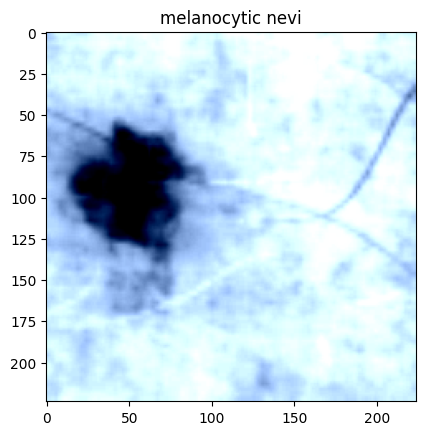

In [12]:
img, label = image_datasets['train'][22]
print(f"Image shape: {img.shape} -> [color_channels, height, width]")
plt.imshow(img.T)
plt.title(class_labels[str(label[0])]);

## Addressing imbalance in dataset

### Class weighting during model training

In [13]:
def get_class_weights(dataset):
    class_counts = [0] * n_classes
    for images, labels in dataset:
        class_counts[labels.item()] += 1

    class_weights = [1 - (x / len(dataset)) for x in class_counts]
    return class_weights

### Using WeightedRandomSampler

In [ ]:
###

### Using Manual Class-wise augmentation

In [14]:
class AugmentedDataset(Dataset):
    def __init__(self, augmented_data):
        self.data = augmented_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

In [15]:
def augment_class(dataset, class_idx, target_count, transform):
    class_indices = [i for i, (img, label) in enumerate(dataset) if label == class_idx]
    current_count = len(class_indices)

    # Keep original images
    augmented_images = [(dataset[i][0], dataset[i][1]) for i in class_indices]

    # Augment until we reach the target count
    while len(augmented_images) < target_count:
        random_idx = random.choice(class_indices)
        img, label = dataset[random_idx]
        augmented_img = transform(img)
        augmented_images.append((augmented_img, label))

    return AugmentedDataset(augmented_images[:target_count])

### Oversampling minor classes

In [16]:
augmented_class_0 = augment_class(image_datasets['train'], class_idx=0, target_count=700, transform=data_transforms['train'])
augmented_class_1 = augment_class(image_datasets['train'], class_idx=1, target_count=700, transform=data_transforms['train'])
augmented_class_3 = augment_class(image_datasets['train'], class_idx=3, target_count=700, transform=data_transforms['train'])
augmented_class_6 = augment_class(image_datasets['train'], class_idx=6, target_count=700, transform=data_transforms['train'])

In [17]:
class_2_indices = [i for i, (_, label) in enumerate(image_datasets['train']) if label == 2]
class_4_indices = [i for i, (_, label) in enumerate(image_datasets['train']) if label == 4]

# Randomly sample 700 instances from class 5
class_5_indices = [i for i, (_, label) in enumerate(image_datasets['train']) if label == 5]
random_class_5_indices = random.sample(class_5_indices, 700)

In [18]:
# Combine augmented and original datasets
balanced_dataset = ConcatDataset([
    augmented_class_0,
    augmented_class_1,
    augmented_class_3,
    augmented_class_6,
    Subset(image_datasets['train'], class_2_indices),  # Keep class 2 as is
    Subset(image_datasets['train'], class_4_indices),  # Keep class 4 as is
    Subset(image_datasets['train'], random_class_5_indices)  # Randomly sampled 700 instances from class 5
])

In [19]:
print_data_distro(balanced_dataset,n_classes)

Class actinic keratoses and intraepithelial carcinoma: 700 instances
Class basal cell carcinoma: 700 instances
Class benign keratosis-like lesions: 769 instances
Class dermatofibroma: 700 instances
Class melanoma: 779 instances
Class melanocytic nevi: 700 instances
Class vascular lesions: 700 instances


### Row sampling without replacement

In [39]:
K = 4 # number of base models
totalnum_traindata = len(image_datasets['train'])
num_traindata = totalnum_traindata // K
num_traindata

1751

In [40]:
indices = list(range(totalnum_traindata))
train_loaders = []
print(f"trainset size: {len(image_datasets['train'])}")
for i in range(K):
    lower_idx = num_traindata * i
    upper_idx = num_traindata * (i + 1)

    #giving the extra data instance to the last model
    # if (i+1 == K):
    #     upper_idx += 1

    part_tr = indices[lower_idx : upper_idx]

    trainset_sub = Subset(image_datasets['train'], part_tr)

    print(f"trainset_sub: {len(trainset_sub)}")
    train_loader = torch.utils.data.DataLoader(trainset_sub, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
    train_loaders.append(train_loader)

trainset size: 7007
trainset_sub: 1751
trainset_sub: 1751
trainset_sub: 1751
trainset_sub: 1751


### Load base models and modifying last layer

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [23]:
model_name = 'densenet169'

def load_base_models(model_name, K):
    base_models = []
    for i in range(K):
        if model_name == 'densenet169':
            base_model = models.densenet169(weights=DenseNet169_Weights.IMAGENET1K_V1)

            # freezing previous layers
            for param in base_model.features.parameters():
                param.requires_grad = False

            # Substituting last layer
            num_ftrs = base_model.classifier.in_features
            base_model.classifier = nn.Linear(num_ftrs, n_classes)
            base_model.to(device)
            base_models.append(base_model)

    return base_models

base_models = load_base_models(model_name, K)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 166MB/s] 


### Training base models

In [24]:
def train_base_model(model, dataloader, use_class_weights=False, epochs=25, lr=0.01, step_size=7, gamma=0.1):

  if use_class_weights:
    class_weights = get_class_weights(dataloader.dataset)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))
  else:
    criterion = nn.CrossEntropyLoss()

  optimizer = optim.SGD(model.parameters(), lr=lr)
  step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=step_size,gamma=gamma)

  model.train()

  for epoch in range(epochs):
      running_loss = 0.0
      running_corrects = 0
      for i, data in enumerate(tqdm(dataloader, ncols=100, desc='epoch '+str(epoch+1))):

          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          # if len(labels) == BATCH_SIZE:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          _,preds = torch.max(outputs,1)
          labels = labels.squeeze().long()
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / num_traindata
      epoch_acc = running_corrects.double() / num_traindata

      print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

  return model

In [43]:
trained_models = []
for i, model in enumerate(base_models):
    print(f'training base model {i+1}')
    model = train_base_model(model, train_loaders[i])
    trained_models.append(model)
    print()

training base model 1


epoch 1: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


Loss: 0.7618 Acc: 0.6796


epoch 2: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7613 Acc: 0.6710


epoch 3: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Loss: 0.7590 Acc: 0.6859


epoch 4: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Loss: 0.7344 Acc: 0.6916


epoch 5: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7416 Acc: 0.6848


epoch 6: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7524 Acc: 0.6676


epoch 7: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Loss: 0.7479 Acc: 0.6796


epoch 8: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7395 Acc: 0.6859


epoch 9: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7378 Acc: 0.6819


epoch 10: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7388 Acc: 0.6756


epoch 11: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Loss: 0.7290 Acc: 0.6945


epoch 12: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7430 Acc: 0.6785


epoch 13: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7389 Acc: 0.6945


epoch 14: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Loss: 0.7307 Acc: 0.6876


epoch 15: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7270 Acc: 0.6962


epoch 16: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7226 Acc: 0.6853


epoch 17: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


Loss: 0.7293 Acc: 0.6950


epoch 18: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7310 Acc: 0.6865


epoch 19: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7435 Acc: 0.6859


epoch 20: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7492 Acc: 0.6773


epoch 21: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7321 Acc: 0.6842


epoch 22: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7179 Acc: 0.6910


epoch 23: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


Loss: 0.7161 Acc: 0.6945


epoch 24: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7242 Acc: 0.6922


epoch 25: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7139 Acc: 0.6967

training base model 2


epoch 1: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Loss: 0.7777 Acc: 0.6756


epoch 2: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7870 Acc: 0.6688


epoch 3: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7706 Acc: 0.6619


epoch 4: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7355 Acc: 0.6859


epoch 5: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7697 Acc: 0.6739


epoch 6: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7766 Acc: 0.6670


epoch 7: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


Loss: 0.7563 Acc: 0.6802


epoch 8: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7696 Acc: 0.6830


epoch 9: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7657 Acc: 0.6705


epoch 10: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Loss: 0.7462 Acc: 0.6848


epoch 11: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7444 Acc: 0.6768


epoch 12: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7581 Acc: 0.6808


epoch 13: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


Loss: 0.7786 Acc: 0.6608


epoch 14: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7472 Acc: 0.6790


epoch 15: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7531 Acc: 0.6762


epoch 16: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


Loss: 0.7456 Acc: 0.6785


epoch 17: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7445 Acc: 0.6830


epoch 18: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7591 Acc: 0.6785


epoch 19: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7493 Acc: 0.6779


epoch 20: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Loss: 0.7484 Acc: 0.6887


epoch 21: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7187 Acc: 0.6910


epoch 22: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7371 Acc: 0.6808


epoch 23: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Loss: 0.7222 Acc: 0.6848


epoch 24: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7374 Acc: 0.6859


epoch 25: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7557 Acc: 0.6802

training base model 3


epoch 1: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


Loss: 0.7206 Acc: 0.7042


epoch 2: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7114 Acc: 0.7002


epoch 3: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7215 Acc: 0.6985


epoch 4: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


Loss: 0.6977 Acc: 0.7025


epoch 5: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7194 Acc: 0.6967


epoch 6: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7012 Acc: 0.7127


epoch 7: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


Loss: 0.6823 Acc: 0.7162


epoch 8: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.6830 Acc: 0.7144


epoch 9: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.6980 Acc: 0.7110


epoch 10: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


Loss: 0.7023 Acc: 0.7133


epoch 11: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7062 Acc: 0.7047


epoch 12: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.6923 Acc: 0.7065


epoch 13: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


Loss: 0.6923 Acc: 0.7167


epoch 14: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6841 Acc: 0.7025


epoch 15: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6865 Acc: 0.7082


epoch 16: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6795 Acc: 0.7184


epoch 17: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7073 Acc: 0.7030


epoch 18: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6758 Acc: 0.7139


epoch 19: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Loss: 0.6840 Acc: 0.7093


epoch 20: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.6856 Acc: 0.7116


epoch 21: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6852 Acc: 0.7065


epoch 22: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6972 Acc: 0.7173


epoch 23: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.6779 Acc: 0.7116


epoch 24: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.6731 Acc: 0.7144


epoch 25: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Loss: 0.6918 Acc: 0.7025

training base model 4


epoch 1: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7552 Acc: 0.6739


epoch 2: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7272 Acc: 0.6853


epoch 3: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Loss: 0.7294 Acc: 0.6950


epoch 4: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7063 Acc: 0.6990


epoch 5: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7254 Acc: 0.6922


epoch 6: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7288 Acc: 0.6916


epoch 7: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7024 Acc: 0.7053


epoch 8: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7017 Acc: 0.7013


epoch 9: 100%|██████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6969 Acc: 0.7047


epoch 10: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


Loss: 0.7056 Acc: 0.7047


epoch 11: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.7058 Acc: 0.7047


epoch 12: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.7082 Acc: 0.7065


epoch 13: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Loss: 0.6940 Acc: 0.7042


epoch 14: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


Loss: 0.6991 Acc: 0.7002


epoch 15: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6944 Acc: 0.7053


epoch 16: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


Loss: 0.6997 Acc: 0.6962


epoch 17: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6982 Acc: 0.7002


epoch 18: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6823 Acc: 0.7110


epoch 19: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Loss: 0.6825 Acc: 0.7025


epoch 20: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6988 Acc: 0.7007


epoch 21: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6997 Acc: 0.7036


epoch 22: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6938 Acc: 0.7030


epoch 23: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6784 Acc: 0.7025


epoch 24: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


Loss: 0.6924 Acc: 0.7105


epoch 25: 100%|█████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]

Loss: 0.6855 Acc: 0.7093



## Evaluating ensembled models

### Balancing validation dataset

In [26]:
augmented_val_class_0 = augment_class(image_datasets['val'], class_idx=0, target_count=110, transform=data_transforms['val'])
augmented_val_class_1 = augment_class(image_datasets['val'], class_idx=1, target_count=110, transform=data_transforms['val'])
augmented_val_class_3 = augment_class(image_datasets['val'], class_idx=3, target_count=110, transform=data_transforms['val'])
augmented_val_class_6 = augment_class(image_datasets['val'], class_idx=6, target_count=110, transform=data_transforms['val'])

In [27]:
class_2_val_indices = [i for i, (_, label) in enumerate(image_datasets['val']) if label == 2]
class_4_val_indices = [i for i, (_, label) in enumerate(image_datasets['val']) if label == 4]

# Randomly sample 700 instances from class 5
class_5_val_indices = [i for i, (_, label) in enumerate(image_datasets['val']) if label == 5]
random_class_5_val_indices = random.sample(class_5_val_indices, 110)

In [28]:
# Combine augmented and original datasets
balanced_val_dataset = ConcatDataset([
    augmented_val_class_0,
    augmented_val_class_1,
    augmented_val_class_3,
    augmented_val_class_6,
    Subset(image_datasets['val'], class_2_val_indices),  # Keep class 2 as is
    Subset(image_datasets['val'], class_4_val_indices),  # Keep class 4 as is
    Subset(image_datasets['val'], random_class_5_val_indices)  # Randomly sampled 700 instances from class 5
])

# Create DataLoader
balanced_val_loader = DataLoader(balanced_val_dataset, batch_size=32, shuffle=True)

In [29]:
print_data_distro(balanced_val_dataset,n_classes)

Class actinic keratoses and intraepithelial carcinoma: 110 instances
Class basal cell carcinoma: 110 instances
Class benign keratosis-like lesions: 110 instances
Class dermatofibroma: 110 instances
Class melanoma: 111 instances
Class melanocytic nevi: 110 instances
Class vascular lesions: 110 instances


In [37]:
val_loader = DataLoader(image_datasets['val'], batch_size=32, shuffle=True)

### Implementing soft voting

In [30]:
def soft_voting(model_outputs, batch_size):
  soft_preds = []
  soft_pred_probs = []
  for i in range(batch_size):
    # stacking outputs for each data instance from K base models
    datapoint_outputs = []
    for j in range(K):
      datapoint_outputs.append(model_outputs[j][i])
    pred_probs = torch.stack(datapoint_outputs)
    pred_prob_avg = torch.mean(pred_probs, dim=0)
    soft_pred_probs.append(pred_prob_avg)
    # print(f'average prediction probabilities of instance {i+1}: {pred_prob_avg}')
    soft_pred = torch.argmax(pred_prob_avg)
    soft_preds.append(soft_pred)

  return torch.tensor(soft_preds), torch.stack(soft_pred_probs)

### performance metrics

In [31]:
!pip install torchmetrics

In [32]:
import torchmetrics
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, AUROC
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
def calc_metrics(predicted_labels, pred_probs, ground_truth_labels, num_classes):
  metrics = {}

  accuracy = Accuracy(task="multiclass", num_classes=num_classes)
  accuracy(predicted_labels, ground_truth_labels)
  metrics['accuracy'] = accuracy.compute()

  precision = Precision(task="multiclass", average='macro', num_classes=num_classes)
  precision(predicted_labels, ground_truth_labels)
  metrics['precision'] = precision.compute()

  recall = Recall(task="multiclass", average='macro', num_classes=num_classes)
  recall(predicted_labels, ground_truth_labels)
  metrics['recall'] = recall.compute()

  f1_score = F1Score(task="multiclass", average='macro', num_classes=num_classes)
  f1_score(predicted_labels, ground_truth_labels)
  metrics['f1_score'] = f1_score.compute()

  auroc = AUROC(task="multiclass", num_classes=num_classes)
  auroc(pred_probs, ground_truth_labels)
  metrics['auroc'] = auroc.compute()

  return metrics

In [34]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [35]:
def plot_confusion_matrix(cm, class_labels):
  plt.figure(figsize=(10,7))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()


In [46]:
def find_metric_from_cm(cm):
  # Convert the tensor to numpy for easier calculation
  confusion_matrix = cm.numpy()
  # Initialize lists to store precision, recall, and F1-score for each class
  precision_list = []
  recall_list = []
  f1_list = []

  # Calculate precision, recall, and F1-score for each class
  for i in range(confusion_matrix.shape[0]):
      TP = confusion_matrix[i, i]
      FP = confusion_matrix[:, i].sum() - TP
      FN = confusion_matrix[i, :].sum() - TP

      # Precision = TP / (TP + FP), handle divide by zero
      precision = TP / (TP + FP) if (TP + FP) > 0 else 0
      precision_list.append(precision)

      # Recall = TP / (TP + FN), handle divide by zero
      recall = TP / (TP + FN) if (TP + FN) > 0 else 0
      recall_list.append(recall)

      # F1-score = 2 * (precision * recall) / (precision + recall), handle divide by zero
      f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
      f1_list.append(f1)

  # Print precision, recall, and F1-score for each class
  for i in range(len(precision_list)):
      print(f"Class {i}: Precision = {precision_list[i]:.2f}, Recall = {recall_list[i]:.2f}, F1-score = {f1_list[i]:.2f}")


Batch 1 accuracy: 68.75%
Batch 2 accuracy: 71.88%
Batch 3 accuracy: 90.62%
Batch 4 accuracy: 75.00%
Batch 5 accuracy: 68.75%
Batch 6 accuracy: 75.00%
Batch 7 accuracy: 71.88%
Batch 8 accuracy: 75.00%
Batch 9 accuracy: 71.88%
Batch 10 accuracy: 81.25%
Batch 11 accuracy: 71.88%
Batch 12 accuracy: 59.38%
Batch 13 accuracy: 71.88%
Batch 14 accuracy: 78.12%
Batch 15 accuracy: 78.12%
Batch 16 accuracy: 65.62%
Batch 17 accuracy: 75.00%
Batch 18 accuracy: 71.88%
Batch 19 accuracy: 71.88%
Batch 20 accuracy: 84.38%
Batch 21 accuracy: 65.62%
Batch 22 accuracy: 65.62%
Batch 23 accuracy: 62.50%
Batch 24 accuracy: 78.12%
Batch 25 accuracy: 65.62%
Batch 26 accuracy: 65.62%
Batch 27 accuracy: 65.62%
Batch 28 accuracy: 84.38%
Batch 29 accuracy: 62.50%
Batch 30 accuracy: 68.75%
Batch 31 accuracy: 59.38%
Batch 32 accuracy: 90.91%
Average accuracy: 72.27%
{'accuracy': tensor(0.7188), 'precision': tensor(0.5183), 'recall': tensor(0.3329), 'f1_score': tensor(0.3542), 'auroc': tensor(0.8658)}
Confusion Matri

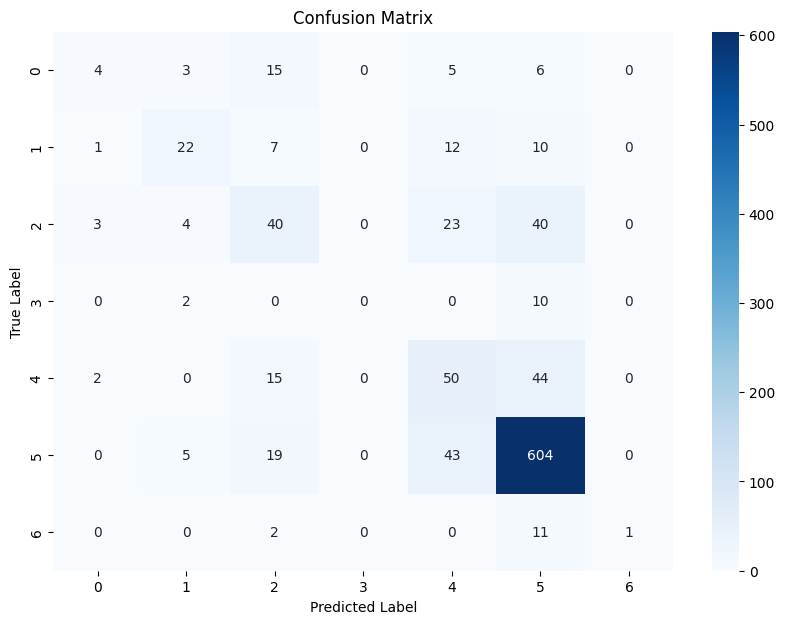

Class 0: Precision = 0.40, Recall = 0.12, F1-score = 0.19
Class 1: Precision = 0.61, Recall = 0.42, F1-score = 0.50
Class 2: Precision = 0.41, Recall = 0.36, F1-score = 0.38
Class 3: Precision = 0.00, Recall = 0.00, F1-score = 0.00
Class 4: Precision = 0.38, Recall = 0.45, F1-score = 0.41
Class 5: Precision = 0.83, Recall = 0.90, F1-score = 0.87
Class 6: Precision = 1.00, Recall = 0.07, F1-score = 0.13


In [47]:
# evaluation

def make_prediction(trained_models, data_loader):
    model.eval()
    acc = 0

    predicted_labels = []
    probs_list = []
    ground_truth_labels = []

    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            model_outputs = []
            for base_model in trained_models:
                outputs = model(inputs)

                outputs = outputs.softmax(dim=-1)
                model_outputs.append(outputs)

            batch_size = inputs.shape[0]
            preds, probs = soft_voting(model_outputs, batch_size)
            preds = preds.to(device)

            targets = targets.squeeze().long()
            # targets = targets.float().resize_(len(targets), 1)

            predicted_labels.append(preds.cpu())
            probs_list.append(probs.cpu())
            ground_truth_labels.append(targets.cpu())

            batch_acc = accuracy_fn(targets, preds)
            print(f'Batch {i+1} accuracy: {batch_acc:.2f}%')
            acc += batch_acc
        print(f'Average accuracy: {acc/len(data_loader):.2f}%')

        predicted_labels = torch.cat(predicted_labels)
        ground_truth_labels = torch.cat(ground_truth_labels)
        probs_list = torch.cat(probs_list, dim=0)

        result = calc_metrics(predicted_labels, probs_list, ground_truth_labels, n_classes)
        print(result)

        cm = torchmetrics.functional.confusion_matrix(predicted_labels, ground_truth_labels, num_classes=n_classes, task="multiclass")
        print(f'Confusion Matrix: \n{cm}')
        plot_confusion_matrix(cm, class_labels)
        find_metric_from_cm(cm)        


make_prediction(trained_models, val_loader)